In [1]:
# Required installations (run once)
!brew install wget  # Added by Miles
!pip install --upgrade --ignore-installed wrapt  # Added by Miles
!pip install tensorflow==2.0.0-beta0  # Edited by Miles (switch to CPU version)
!pip install tensorflow_datasets  # Added by Miles

Updating Homebrew...
==> Auto-updated Homebrew!
Updated 3 taps (homebrew/core, homebrew/cask and caskroom/versions).
==> Updated Formulae
ruby-build ✔    dep             hub             presto          typescript
ammonite-repl   firebase-cli    istioctl        ship            yarn
angular-cli     fluxctl         libev           skopeo          yle-dl
cocoapods       goreleaser      lxc             terragrunt
conan           helmfile        openfortivpn    topgrade

Error: wget 1.20.2 is already installed
To upgrade to 1.20.3_1, run `brew upgrade wget`.
     |████████████████████████████████| 686kB 2.9MB/s 
     |████████████████████████████████| 153kB 9.2MB/s 
     |████████████████████████████████| 829kB 3.0MB/s 
  Stored in directory: /Users/werlindo/Library/Caches/pip/wheels/5b/d7/0f/e58eae695403de585269f4e4a94e0cd6ca60ec0c202936fa4a
  Stored in directory: /Users/werlindo/Library/Caches/pip/wheels/0c/61/d2/d6b7317325828fbb39ee6ad559dbe4664d0896da4721bf379e
  Stored in directory: /Us

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
keras = tf.keras

In [4]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

### Data download

Use [TensorFlow Datasets](http://tensorflow.org/datasets) to load the cats and dogs dataset.

This `tfds` package is the easiest way to load pre-defined data. If you have your own data, and are interested in importing using it with TensorFlow see [loading image data](../load_data/images.ipynb)


In [5]:
SPLIT_WEIGHTS = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)

cat_dog_dataset = tfds.load('cats_vs_dogs',
                            split=list(splits),
                            with_info=True,
                            as_supervised=True)

In [6]:
type(cat_dog_dataset)

tuple

In [8]:
(raw_train, raw_validation, raw_test), metadata = cat_dog_dataset

In [9]:
type(raw_train)

tensorflow.python.data.ops.dataset_ops._OptionsDataset

In [10]:
type(raw_validation)

tensorflow.python.data.ops.dataset_ops._OptionsDataset

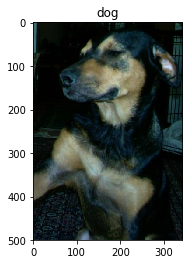

In [63]:
# Set up a function to translate 1 to dog, 0 to cat
get_label_name = metadata.features['label'].int2str

# Plot the first two images
for image, label in raw_train.take(1):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [64]:
image.shape

TensorShape([500, 343, 3])

### Format the Data

Use the `tf.image` module to format the images for the task.

Resize the images to a fixes input size, and rescale the input channels to a range of `[-1,1]`

<!-- TODO(markdaoust): fix the keras_applications preprocessing functions to work in tf2 -->

In [65]:
IMG_SIZE = 160 # All images will be resized to 160x160

def prepare_image(image, height=IMG_SIZE, width=IMG_SIZE):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (height, width))
    return image

In [67]:
image_prepared = prepare_image(image)

In [68]:
image_prepared.shape

TensorShape([160, 160, 3])

In [69]:
train_images = [(img.numpy(), label.numpy())
                for (img, label) in raw_train.take(10000)]

In [70]:
test_images = [(img.numpy(), label.numpy())
               for (img, label) in raw_test.take(1000)]

Text(0.5, 1.0, 'dog')

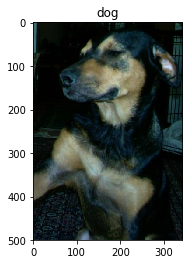

In [71]:
plt.imshow(train_images[0][0])
plt.title(get_label_name(train_images[0][1]))

In [72]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [73]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [74]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
])

In [75]:
def extract_features(image):
    """Return a vector of 1280 deep features for image."""
    image_resized = prepare_image(image)
    image_np = image_resized.numpy()
    images_np = np.expand_dims(image_np, axis=0)
    image_np.shape, images_np.shape
    deep_features = model.predict(images_np)
    return deep_features[0]

In [76]:
extract_features(image)

array([0.44436017, 0.        , 0.        , ..., 0.        , 0.05695944,
       1.2433755 ], dtype=float32)

In [77]:
train_X_img, train_y = zip(*train_images)
test_X_img, test_y = zip(*test_images)

# Extract features from some images

In [78]:
TRAIN_LIMIT = 1000
TEST_LIMIT = 200

In [79]:
train_X_small = [extract_features(img)
                 for img in train_X_img[:TRAIN_LIMIT]]
test_X_small = [extract_features(img)
                for img in test_X_img[:TEST_LIMIT]]

In [80]:
train_y_small = train_y[:TRAIN_LIMIT]
test_y_small = test_y[:TEST_LIMIT]

# Logistic Regression on Deep Features

In [81]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='lbfgs')
lr.fit(train_X_small, train_y_small)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [44]:
train_preds = lr.predict(train_X_small)
(sum(train_y_small) / len(train_y_small),
 sum(train_preds == train_y_small) / len(train_y_small))

(0.479, 1.0)

In [45]:
test_preds = lr.predict(test_X_small)
(sum(test_y_small) / len(test_y_small),
 sum(test_preds == test_y_small) / len(test_y_small))

(0.54, 0.975)

In [46]:
idxs=np.argsort(np.abs(lr.coef_[0]))[::-1]

(array([  3.,   3.,  27.,  65., 164., 323., 416., 237.,  34.,   8.]),
 array([-0.29895372, -0.25000516, -0.2010566 , -0.15210804, -0.10315948,
        -0.05421092, -0.00526236,  0.04368619,  0.09263475,  0.14158331,
         0.19053187]),
 <a list of 10 Patch objects>)

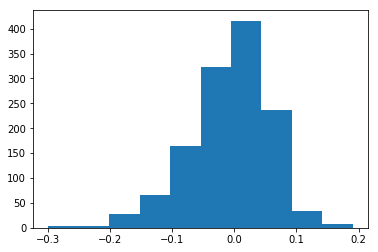

In [47]:
plt.hist(lr.coef_[0])

In [48]:
import pandas as pd
pd.DataFrame({'values': lr.coef_[0][idxs], 'idx': idxs})

values   idx
0    -0.298954   333
1    -0.260865  1265
2    -0.256802   704
3    -0.237915   631
4    -0.223827   511
5    -0.222115  1125
6     0.190532  1106
7     0.187657   339
8    -0.183940   847
9    -0.183843   268
10   -0.178990  1252
11   -0.178799   271
12   -0.177945  1169
13   -0.174522   588
14   -0.174269   880
15   -0.172777   705
16   -0.171924   730
17   -0.170849   785
18   -0.170609  1082
19    0.169404   999
20   -0.168558   306
21   -0.166995   544
22   -0.166916  1268
23   -0.166719  1206
24   -0.166288   931
25   -0.161885   932
26    0.161542   804
27   -0.161188   924
28   -0.160167  1148
29    0.159260   424
...        ...   ...
1250 -0.001097   721
1251 -0.001089  1245
1252  0.001078   109
1253  0.001067    26
1254 -0.001009   276
1255  0.000774    30
1256  0.000764   902
1257 -0.000674     2
1258 -0.000674   501
1259 -0.000673   873
1260 -0.000665  1277
1261 -0.000652   699
1262  0.000616  1099
1263  0.000583   160
1264  0.000557  1178
1265  0.000495   767
1266  0.000401   125
1267  0.000391   921
1268 -0.000368  1031
1269  0.000364   712
1270 -0.000358  1226
1271 -0.000308   597
1272  0.000308    79
1273  0.000304   427
1274  0.000230   928
1275 -0.000189   649
1276 -0.000141   810
1277  0.000139   908
1278  0.000102  1203
1279  0.000015   289

[1280 rows x 2 columns]

# Random Forest on Deep Features

In [49]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
rfc.fit(train_X_small, train_y_small)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [50]:
train_preds = rfc.predict(train_X_small)
(sum(train_y_small) / len(train_y_small),
 sum(train_preds == train_y_small) / len(train_y_small))

(0.479, 1.0)

In [51]:
test_df = pd.DataFrame(test_X_small)

In [52]:
test_df.head()

0         1         2         3         4         5         6     \
0  0.000000  0.000000  0.187428  0.000000  0.093927  2.573779  0.000000   
1  0.661587  0.000000  0.329316  0.127950  0.000000  0.067588  0.426817   
2  0.000000  0.729683  0.500268  0.000000  0.240421  1.062595  0.118038   
3  0.015244  0.112355  0.015764  0.319685  0.033733  0.128896  1.839036   
4  0.000000  0.000000  0.645050  0.026076  0.000000  3.957061  0.000000   

       7         8         9       ...         1270      1271      1272  \
0  0.006866  0.573680  0.034276    ...     0.261767  0.000000  0.070764   
1  0.050561  0.695179  0.000000    ...     0.093736  0.487123  0.000000   
2  0.754541  0.530771  0.906375    ...     0.000000  0.049220  0.346053   
3  0.042552  0.048562  1.348278    ...     0.813497  0.084459  2.797387   
4  0.000000  0.311983  0.762905    ...     0.535164  0.000000  0.000000   

       1273      1274      1275      1276      1277      1278      1279  
0  0.000000  1.265453  0.018613  0.000000  0.000000  0.000000  0.335324  
1  0.026983  0.009179  0.000000  0.860023  0.000000  2.083969  0.905496  
2  0.838386  0.000000  0.612410  0.108159  0.218859  2.681238  0.421746  
3  0.000000  0.000000  0.541578  0.021995  0.000000  0.160714  0.445934  
4  0.000000  0.413561  0.066226  0.000000  0.000000  0.047528  0.822701  

[5 rows x 1280 columns]

In [53]:
test_preds = rfc.predict(test_X_small)
(sum(test_y_small) / len(test_y_small),
 sum(test_preds == test_y_small) / len(test_y_small))

(0.54, 0.985)

In [54]:
rf_idxs = np.argsort(rfc.feature_importances_)[::-1]

In [55]:
rf_idxs

array([ 704, 1066,  738, ...,  348,  460,  857])

In [56]:
rfc.feature_importances_[rf_idxs]

array([3.62670035e-02, 3.53392863e-02, 2.64130974e-02, ...,
       2.19511429e-05, 1.93851930e-05, 1.75343383e-05])

In [57]:
permuted_test_df = test_df.copy()
idx_list = rf_idxs[:10]
for idx in idx_list:
    important_feature = test_df.loc[:, idx].copy().values
    np.random.shuffle(important_feature)
    permuted_test_df.loc[:, idx] = important_feature

In [58]:
test_preds = rfc.predict(permuted_test_df)
(sum(test_y_small) / len(test_y_small),
 sum(test_preds == test_y_small) / len(test_y_small))

(0.54, 0.985)